In [1]:
# Imports
import urllib
import zipfile

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
from IPython.display import HTML, display


# Functions to remove outliers in discrete cell designs
def remove_outliers(x, cutoff_type="IQR", cutoff_thresh=2):
    """
    Exclude outliers from a vector.
    """
    x = x.copy()
    if cutoff_type == "IQR":
        iqr = stats.iqr(x)
        low = np.percentile(x, 25) - cutoff_thresh * iqr
        high = np.percentile(x, 75) + cutoff_thresh * iqr
        return x[(x >= low) & (x <= high)]
    elif cutoff_type == "z-score":
        sd = np.std(x)
        low = np.mean(x) - cutoff_thresh * sd
        high = np.mean(x) + cutoff_thresh * sd
        return x[(x >= low) & (x <= high)]
    elif cutoff_type == "MAD":
        mad = stats.median_abs_deviation(x, scale="normal")
        med = np.median(x)
        low = med - cutoff_thresh * mad
        high = med + cutoff_thresh * mad
        return x[(x >= low) & (x <= high)]
    elif cutoff_type == "WINS":
        sd = np.std(x)
        low = np.mean(x) - cutoff_thresh * sd
        high = np.mean(x) + cutoff_thresh * sd
        x[x <= low] = low
        x[x >= high] = high
        return x
    else:
        raise ValueError(
            f"Cutoff type {cutoff_type} not understood. Must be 'IQR' or 'SD'"
        )


def remove_outliers_common(x, y, cutoff_type="IQR", cutoff_thresh=2):
    """
    Exclude outliers from two vectors, using the same cutoff for both.
    """
    xy = np.concatenate([x, y])
    x = x.copy()
    y = y.copy()
    if cutoff_type == "IQR":
        iqr = stats.iqr(xy)
        low = np.percentile(xy, 25) - cutoff_thresh * iqr
        high = np.percentile(xy, 75) + cutoff_thresh * iqr
        return (
            x[(x >= low) & (x <= high)],
            y[(y >= low) & (y <= high)],
        )

    elif cutoff_type == "z-score":
        sd = np.std(xy)
        low = np.mean(xy) - cutoff_thresh * sd
        high = np.mean(xy) + cutoff_thresh * sd
        return (
            x[(x >= low) & (x <= high)],
            y[(y >= low) & (y <= high)],
        )

    elif cutoff_type == "MAD":
        mad = stats.median_abs_deviation(x, scale="normal")
        med = np.median(x)
        low = med - cutoff_thresh * mad
        high = med + cutoff_thresh * mad
        return (
            x[(x >= low) & (x <= high)],
            y[(y >= low) & (y <= high)],
        )

    elif cutoff_type == "WINS":
        sd = np.std(xy)
        low = np.mean(xy) - cutoff_thresh * sd
        high = np.mean(xy) + cutoff_thresh * sd
        x[x <= low] = low
        x[x >= high] = high
        y[y <= low] = low
        y[y >= high] = high
        return x, y
    else:
        raise ValueError(
            f"Cutoff type {cutoff_type} not understood. Must be 'IQR' or 'SD'"
        )


def flag_outliers_iqr(x, cutoff_thresh=3):
    """
    Flag the outliers using the IQR method.
    """
    iqr = stats.iqr(x)
    low = np.percentile(x, 25) - cutoff_thresh * iqr
    high = np.percentile(x, 75) + cutoff_thresh * iqr
    return np.array((x <= low) | (x >= high))


def remove_outliers_iter(x, cutoff_type="IQR", cutoff_thresh=2):
    """
    Iteratively exclude outliers from two vectors until none are found.
    """
    x = x.copy()
    if cutoff_type != "WINS":
        x_before = x
        while True:
            x_after = remove_outliers(x_before, cutoff_type, cutoff_thresh)
            if x_before.shape[0] == x_after.shape[0]:
                return x_after
            else:
                x_before = x_after
    else:
        x_before = x
        while True:
            x_after = remove_outliers(x_before, cutoff_type, cutoff_thresh)
            if (x_before == x_after).mean() == 1:
                return x_after
            else:
                x_before = x_after


def compare_tstats_under_exclusions(x, y, cutoff_type="IQR", cutoff_thresh=2):
    """
    Compare two vectors of data and return the t-stats when (1) Outliers
    are excluded based on a common cutoff or (2) Outliers are excluded using
    a condition-specific cutoff
    """
    x_common, y_common = remove_outliers_common(x, y, cutoff_type, cutoff_thresh)
    diff_common = stats.ttest_ind(x_common, y_common).statistic

    x_diff = remove_outliers(x, cutoff_type, cutoff_thresh)
    y_diff = remove_outliers(y, cutoff_type, cutoff_thresh)
    diff_diff = stats.ttest_ind(x_diff, y_diff).statistic
    return [diff_common, diff_diff]


# Plotting functions
def hist_no_edge(x, *args, **kwargs):
    """
    Plot a histogram without the left and right edges. Useful for survival curves.
    """
    bins = kwargs.pop("bins")
    cumulative = kwargs.pop("cumulative", False)
    # Add a bin for all p-values between the upper bin and 1.
    cnt, edges = np.histogram(x, bins=bins.tolist() + [1])
    ax = plt.gca()
    if cumulative:
        prop = cnt.cumsum() / cnt.sum()
        ax.step(edges[:-2], prop[:-1], *args, **kwargs)
    else:
        ax.step(edges[:-2], cnt, *args, **kwargs)


def plot_simulation_results(data, include_iterated=True):
    """
    Plot the survival curve of all the simulations. 
    """
    gb = data.groupby(["Threshold", "Method", "Level"])  # Data by group.

    # Type I error at various alpha levels
    p_05 = gb["$\\alpha_{{05}}$"].mean()
    p_01 = gb["$\\alpha_{{01}}$"].mean()
    p_001 = gb["$\\alpha_{{001}}$"].mean()

    # Labels for lines and panels
    thresholds = [1.5, 2.0, 3.0]
    methods = ["IQR Distance", "z-score", "MAD"]
    if include_iterated:
        levels = ["None", "Across", "Within", "Within, Iterated"]
        labels = ["None", "Across", "Within", "Within, Iter."]
        maxcoord = 4
    else:
        levels = ["None", "Across", "Within"]
        labels = ["None", "Across", "Within"]
        data = data.query("Level != 'Within, Iterated'")
        maxcoord = 3

    ycoords = 0.65 + np.arange(0, 1, 0.06)  # Coordinates to plot legend

    pal = sns.color_palette()[0:4]  # Colors

    # Initialize the plot
    g = sns.FacetGrid(
        data,
        col="Threshold",
        row="Method",
        hue="Level",
        hue_order=levels,
        col_order=thresholds,
        row_order=methods,
        height=3.4,
        aspect=1.2,
        sharey=True,
        sharex=True,
        hue_kws=dict(ls=[(0, ()), (1, (5, 5)), (0, ()), (1, ())]),
    )

    # Map the survival curve to each panel and color
    g.map(
        hist_no_edge,
        "pvalue",
        cumulative=True,
        bins=np.logspace(np.log10(10e-40), np.log10(0.05), 10000),
        lw=1.5,
    )

    # Change the axes labels
    g.set_ylabels("Fraction of Sig. Tests ($p < \\alpha$)")
    g.set_xlabels("Sig. Threshold ($\\alpha$)")
    g.set_titles("Cutoff: {col_name} * {row_name}")

    # Adjust the axes and ticks
    for i, (axe, meth) in enumerate(zip(g.axes, methods)):
        for j, (ax, thresh) in enumerate(zip(axe, thresholds)):
            ax.set_xlim(10e-8, 0.05)
            ax.set_xscale("log")
            ax.set_xticks([10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 0.05])
            ax.set_xticklabels(
                ["10e-8", "10e-7", ".00001", ".0001", ".001", ".01", ".05"]
            )
            ax.set_xticks([], minor=True)
            ax.invert_xaxis()
            ax.annotate(
                f"Type I Error Rate at $[\\alpha_{{05}}, \\alpha_{{01}}, \\alpha_{{001}}]$",
                (1, ycoords[maxcoord]),
                color="black",
                fontsize=10,
                ha="right",
                xycoords="axes fraction",
            )
            _, yh = ax.get_ylim()
            ys = np.round(yh / 6, 2)
            ax.set_yticks(np.arange(0, yh, ys))
            # Add the false-positive annotations
            for k, (lab, lev) in enumerate(zip(labels, levels)):
                ax.annotate(
                    f"{lab}: [{p_05.loc[thresh, meth, lev]:.2f}, "
                    f" {p_01.loc[thresh, meth, lev]:.2f}, "
                    f"{p_001.loc[thresh, meth, lev]:.3f}]",
                    (1, ycoords[k]),
                    color=pal[k],
                    ha="right",
                    xycoords="axes fraction",
                    fontsize=10,
                )

<br/>

In a [recent post](https://quentinandre.net/post/how-not-to-deal-with-outliers), I described a recent paper in psychology that featured inflated false-positive rates for two reasons:
1. Some outliers which should not have been excluded (judging from the pre-registration) were excluded.
2. The outliers were excluded within conditions, rather than across the data.

This discovery encouraged me to do more research on the topic, and to write a paper on outlier exclusions, which was recently accepted for publication.

You can read the paper in full [here](https://quentinandre.net/publication/outliers-blind-hypothesis/) if you are curious, otherwise here are five highlights from the paper:

## 1. By-condition exclusions are relatively common, and the literature has insufficiently discouraged this practice

To assess the prevalence of this practice,  I searched the *Journal of Experimental Psychology: General* for the all papers published since 2019 including the keyword "outlier". This search returned 43 papers, 31 of which included a univariate exclusion procedure. Out of those 31 papers, 9 of them incorrectly excluded outliers by condition.

I also discovered that the most cited papers on the topic of outlier exclusions typically do not discuss the level at which outliers should be excluded (i.e., within vs. across conditions). In fact, the only two papers I found that do discuss this issue make the incorrect recommendation that outliers should be excluded within conditions. The details of this literature surveys are available in the paper, and on the [OSF repository](https://osf.io/3tz76/) of the project.

## 2. Excluding outliers by condition is a paradox, and violates the logic of null-hypothesis testing

To determine if a treatment has an effect, researchers commonly engage in null-hypothesis significance testing (NHST): They compare the observed impact of their treatment to what would be expected if the treatment did not have any effect (the null hypothesis). 

Take the t-test for instance: It compares the observed difference in means between two groups to the differences that would be expected when two groups are independently sampled at random from a common normal distribution. If the observed difference is much more extreme than what this *null distribution* would predict, researchers typically "reject the null," and conclude that the treatment had an effect.

How is this connected to outlier exclusions? Well, when researchers choose to exclude outliers within conditions (rather than across the data), they operate under the assumption that the two conditions are different from each other… and have therefore implicitly rejected the null hypothesis. But if they have already accepted that the null hypothesis is not true, how can they then interpret a statistical test that assumes that the null is true? 

## 3. Excluding outliers by condition will amplify any random difference originally present between the conditions

This paradox is not without consequences. Consider the figure below: The two groups were drawn from the same distribution but, by chance, the values in the “Control” condition are slightly lower than the values in the “Treatment” condition. The panel on the left shows the conclusion that a researcher will reach when comparing the two groups with a t-test.

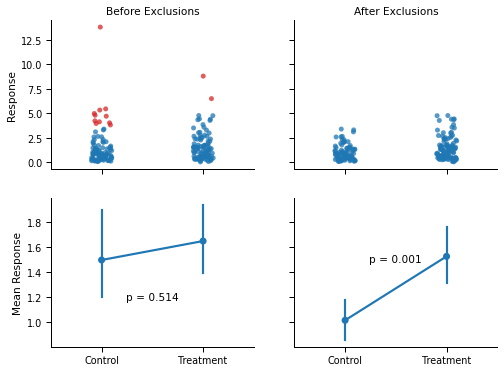

In [2]:
np.random.seed(2389326705)  # Seed for reproducibility

x, y = np.random.lognormal(size=(2, 100))  # Data before exclusions
xt = remove_outliers(x, cutoff_thresh=1.5)  # Data after exclusions
yt = remove_outliers(y, cutoff_thresh=1.5)

# Generating the "before exclusions" dataset, and flagging outliers in it.
resp = x.tolist() + y.tolist()
cond = np.repeat(["Control", "Treatment"], [x.shape[0], y.shape[0]])
df_noexcl = pd.DataFrame(dict(Response=resp, Condition=cond))
df_noexcl["Outliers"] = df_noexcl.groupby("Condition").transform(
    lambda x: flag_outliers_iqr(x, cutoff_thresh=1.5)
)

# Generating the "after exclusions" dataset
resp = xt.tolist() + yt.tolist()
cond = np.repeat(["Control", "Treatment"], [xt.shape[0], yt.shape[0]])
df_excl = pd.DataFrame(dict(Response=resp, Condition=cond))
df_excl["Outliers"] = False
dfs = [df_noexcl, df_excl]

# Plotting the results
pal_rb = sns.color_palette()[0:5:3]
with sns.plotting_context("paper", font_scale=1.1):
    pal = sns.color_palette()
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey="row", sharex=True)
    for ax, d in zip(axes[0], dfs):
        sns.stripplot(
            x="Condition",
            y="Response",
            hue="Outliers",
            data=d,
            alpha=0.75,
            jitter=0.1,
            order=["Control", "Treatment"],
            ax=ax,
            palette=pal_rb,
        )
        sns.despine()
        ax.legend([], [], frameon=False)
        ax.set_xlabel("")
        ax.set_ylabel("")
    for ax, d in zip(axes[1], dfs):
        sns.pointplot(
            x="Condition", y="Response", data=d, order=["Control", "Treatment"], ax=ax,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")

    axes[0][0].set_title("Before Exclusions")
    axes[0][1].set_title("After Exclusions")
    axes[0][0].set_ylabel("Response")
    axes[1][0].set_ylabel("Mean Response")

    pval_before = stats.ttest_ind(x, y, equal_var=False).pvalue
    pval_after = stats.ttest_ind(xt, yt, equal_var=False).pvalue
    axes[1][0].annotate(f"p = {pval_before:.3f}", (0.5, 1.2), ha="center", va="center")
    axes[1][1].annotate(f"p = {pval_after:.3f}", (0.5, 1.5), ha="center", va="center")
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig1"))

Now, the right panel shows what would happen if the researcher decided to exclude outliers within conditions before running the statistical test. Because of the minute difference between conditions, the same high values are flagged as outliers (red dots) by the boxplot in the “Control” condition, but not in the “Treatment” condition. As a consequence, the difference between the two conditions became much larger, and statistically significant (p < .001).

## 4. Excluding outliers by condition will routinely lead to unacceptable increases in Type I errors

This example is not cherry picked. To show the general impact of by-condition exclusions, I simulated a large number of "experiments" conducted over different types of data, using different statistical tests, using different outlier exclusion cutoffs (IQR distance, z-score, and Median Absolute Difference) and thresholds (1.5, 2 or 3 times the IQR distance/z-score/Median Absolute Difference). 

The full details are in the paper, but here is an overview of the results:

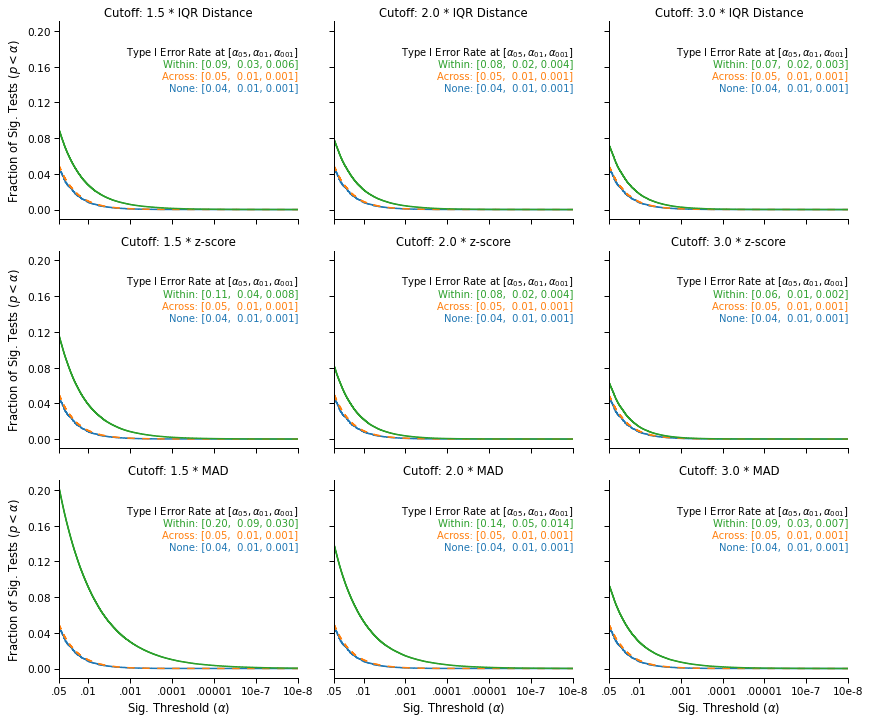

In [3]:
if "df_pvals" not in locals():  # See if the simulations are loaded in memory
    try:  # If not, see if the simulations have been downloaded.
        df_pvals = pd.read_csv("Buffer/Buffered_pvals.csv")
    except:  # Otherwise download them from OSF repository.
        url = "https://osf.io/46bxa/download"
        urllib.request.urlretrieve(url, "Buffer/buffered_pvals.zip")
        with zipfile.ZipFile("Buffer/buffered_pvals.zip", "r") as zip_ref:
            zip_ref.extractall("Buffer")
        df_pvals = pd.read_csv("Buffer/Buffered_pvals.csv")
with sns.plotting_context("paper", font_scale=1.2):
    # Plot the simulation results
    plot_simulation_results(df_pvals, include_iterated=False)
    plt.tight_layout()
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig2"))

This figure displays the survival curves of the tests: The fraction of tests that were significant (on the y-axis) at a given significance threshold (on the x-axis), under different outlier exclusion cutoffs (panels) and different outlier exclusion strategies (lines). 

We see that when no outliers are excluded (blue), or when the outliers are excluded across the data (orange, on top of the blue line), the false-positive rates that we observe are nominal: 5% of tests are significant at α = .05,  1% are significant at α = .01, and .1% are significant at α = .001.

In contrast, we observe an increase in false-positive rates when applying the exclusion cutoff within conditions (green line). The simulations show that the increase is systematic and serious, and that it varies significantly across exclusion cutoffs: The most favorable case shows a 20% increase in the false-positive rate (from 5% to 6%), and the least favorable case shows a 400% increase (from 5% to 20%). In general, we see that the less stringent the cutoff, the more serious the inflation in false-positive rates: Lower cutoffs increase the number of values excluded within each condition, which further amplifies the original differences between the two samples.

This is bad news, but is there any chance that the simulations overstate the problem? Wouldn't it be less severe in real data?

## 5. The problem is also observed in real data, and is further compounded when exclusions are performed "iteratively"

In this section, I will use the data of the paper that I [previously blogged about](https://quentinandre.net/post/how-not-to-deal-with-outliers).

First, the "anomalous exclusions" that I described in the original post turned out to have a benign, if not unusual, explanation: The outliers were "iteratively" excluded within conditions. Any observation with a score lower than “three times the interquartile range below the lower quartile" of its condition was removed from the data, and this procedure was recursively applied again within each condition, until no new outliers are found. Since the pre-registration did not mention this procedure, I originally believed that some outliers should not have been removed from the data.

Now, what would be the impact of such "iterated exclusions"? The figure below provides an estimate of the false-positive rates that one would observe under various outlier exclusion procedures, in the context of this data. Again, the methodological details are available in the paper.

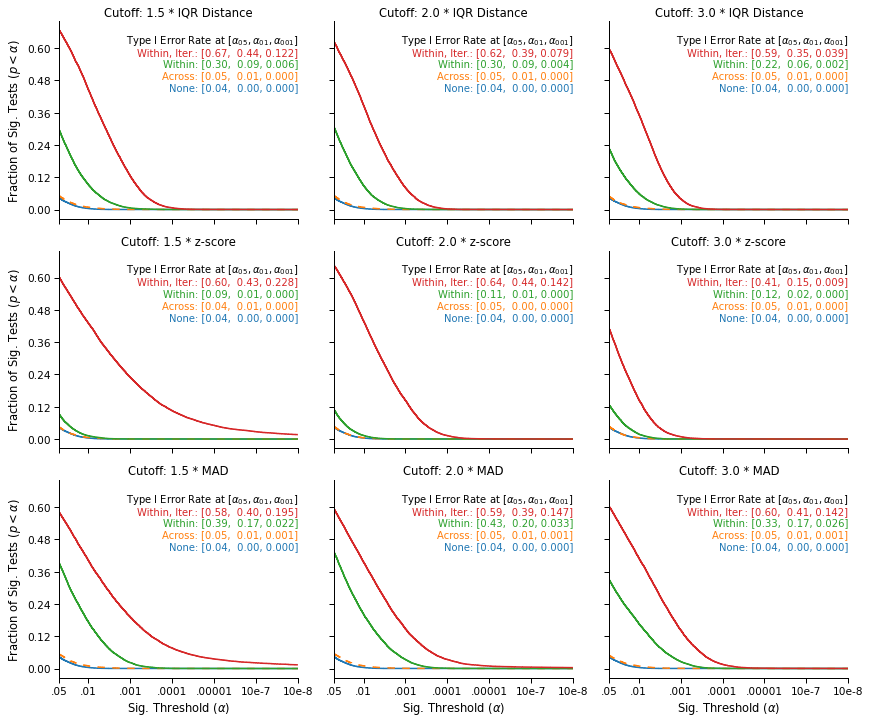

In [4]:
if (
    "df_pvals_ckg_s2" not in locals()
):  # See if the simulations for CKG are loaded in memory
    try:  # If not, see if the simulations have been performed yet.
        df_pvals_ckg_s2 = pd.read_csv("Buffer/Buffered_pvals_ckg_s2.csv")
    except:  # Otherwise perform them.
        url = "https://osf.io/46bxa/download"
        urllib.request.urlretrieve(url, "Buffer/buffered_pvals.zip")
        with zipfile.ZipFile("Buffer/buffered_pvals.zip", "r") as zip_ref:
            zip_ref.extractall("Buffer")
        df_pvals_ckg_s2 = pd.read_csv("Buffer/Buffered_pvals_ckg_s2.csv")

# Plot the simulation results
with sns.plotting_context("paper", font_scale=1.2):
    plot_simulation_results(df_pvals_ckg_s2, include_iterated=True)
    plt.tight_layout()
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig3"))

This figure replicates the Type I error inflation previously observed in simulated data. While outlier exclusions are not associated with higher false-positive rates when they are performed across the data (the orange line, on top of the blue line), the likelihood of a false-positive result increases sharply when outliers are excluded within conditions (the green line): It is always higher than 9% and can be as high as 43%.

Finally, the increase is even stronger when the outliers are iteratively excluded within conditions (the red line): Such iterated exclusions are causing the two conditions to further diverge, and routinely lead to differences that the theoretical null distribution would consider extremely unlikely. In particular, the upper right panel show that the exclusion strategy and cutoff reported in the paper is associated with a false-positive rate of 59%, which translates into a false-positive rate of 29.5% for the directional hypothesis that was pre-registered.

Note that it does not mean that the hypothesis of the paper is false, or that the paper is a false-positive. It only confirms that within-condition exclusions can lead to unacceptably high false-positive rates (even in real, non-simulated data), particularly when the exclusions are performed iteratively.

In the second part of this blog post, I will discuss a more general result of the paper: Any outlier exclusion procedure that is not blind to the hypothesis that researchers want to test may result in inflated false-positive rates.